In [1]:
import torch
from torch import nn
import torch.distributions as dist
from torch.utils.data import DataLoader

torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

from time import time

In [2]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - Hellinger - 1to1

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim*(self.xdim+1)/2))    # changed to take as input the parameters of the tgauss
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

    def forward(self, params):

        output = self.network(params)
        
        weights = torch.ones(output[:, 0].shape)
        mus = torch.exp(output[:, 1:self.xdim+1])                                                      
        covs = torch.exp(output[:, self.xdim+1:]) + EPS

        return weights, mus, covs

In [4]:
def generate_random_covariance(dim, lb, ub):
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub)                # strictly positive diagonal
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())                                # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    return cov_matrix

## Test on single Gaussians

In [5]:
ncomp = 1
xdim = 1
nsamples = 100

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp)
model = torch.load('params/truncNNdim1-hellinger-10ep-1to1.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_17312\4078648392.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-hellinger-10ep-1to1.p

In [6]:
test_means = []
test_covs = []
pred_means = []
pred_covs = []

times = []

for i in range(10):
    
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 2))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1] = generate_random_covariance(xdim, -5, 5)

    params = torch.hstack([torch.tensor([1.]), test_means[-1].flatten(), test_covs[-1].flatten()]).reshape(1,3)

    start = time()
    pi_pred, mu_pred, sigma_pred = model(params)
    end = time()
    times.append(end-start)
    
    pred_means.append(mu_pred)
    pred_covs.append(sigma_pred)

print('Average computation time:', np.mean(times))
#print('Test params:', test_means, test_covs)
#print('Pred params:', pi_pred, mu_pred, sigma_pred)

Average computation time: 0.0024399518966674804


In [7]:
import libSOGA

soga_means = []
soga_covs = []
times = []

for i in range(10):

    start = time()
    soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[i])], [np.array(test_covs[i])]))
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})
    end = time()
    times.append(end-start)

    soga_means.append(new_soga_dist.gm.mu[0])
    soga_covs.append(new_soga_dist.gm.sigma[0])

print('Average computation time:', np.mean(times))

Average computation time: 0.00814051628112793


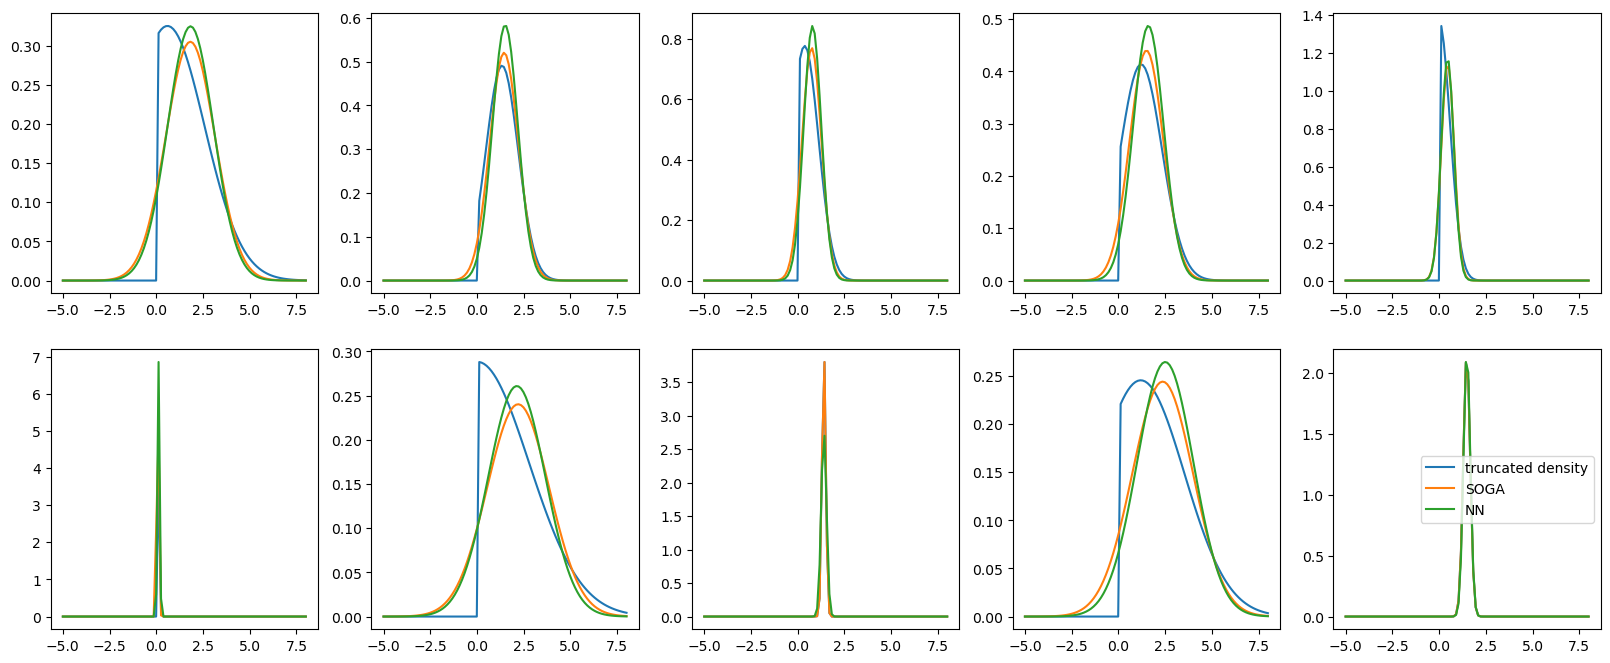

In [8]:
from scipy.stats import truncnorm
from scipy.stats import norm

# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    loc = test_means[i]
    scale = np.sqrt(test_covs[i])
    a = -loc/scale
    b = np.inf

    y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)
    y_soga = norm.pdf(x, soga_means[i], np.sqrt(soga_covs[i])).reshape(x.shape)
    y_nn = norm.pdf(x, pred_means[i].detach().numpy(), np.sqrt(pred_covs[i].detach().numpy())).reshape(x.shape)
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()

plt.savefig('hellinger.pdf')

## Test on Mixtures

In [9]:
def generate_tgauss_dataset(niter, mean_bounds, sigma_bounds, ncomp, xdim):
    """ generates a list of parameters for Gaussian mixtures """
    trunc_gauss = []
    for _ in range(niter):
        weights = torch.rand(ncomp)
        weights = weights / weights.sum()  # Normalize to sum to 1
        means = torch.empty(ncomp, xdim).uniform_(mean_bounds[0], mean_bounds[1])
        covariances = torch.empty(ncomp, xdim, xdim)
        for j in range(ncomp):
            covariances[j] = generate_random_covariance(xdim, sigma_bounds[0], sigma_bounds[1])
        trunc_gauss.append(torch.hstack([weights, means.flatten(), covariances.flatten()]))
    return torch.stack(trunc_gauss)

In [68]:
niter = 10 # number of gaussian mixtures seen during training

ncomp = 2
xdim = 1

lb1_mu = 0
ub1_mu = 1
lb1_sigma = -1
ub1_sigma = 1

trunc_gauss1 = generate_tgauss_dataset(int(0.5*niter), [lb1_mu, ub1_mu], [lb1_sigma, ub1_sigma], ncomp, xdim)

lb2_mu = 0
ub2_mu = 20
lb2_sigma = -5
ub2_sigma = 5

trunc_gauss2 = generate_tgauss_dataset(int(0.5*niter), [lb2_mu, ub2_mu], [lb2_sigma, ub2_sigma], ncomp, xdim)

trunc_gauss = torch.vstack([trunc_gauss1, trunc_gauss2])
trunc_gauss = trunc_gauss[torch.randperm(len(trunc_gauss))]

The main idea is to rewrite a truncated mixture as a mixture of truncated Gaussians.

Consider the truncated mixture $\sum_i \pi_i \mathcal{N}(\mu_i, \Sigma_i) \big|_{x > 0}$. It has density ($\phi(x: \mu, \Sigma)$ denotes the density of a Gaussian with mean $\mu$ and covariance matrix $\Sigma$)
$$ \frac{\sum_i \pi_i \phi(x ; \mu_i, \Sigma_i) \mathbb{I}_{x>0}}{\sum_j \pi_j \int_{x > 0} \phi(x; \mu_j, \Sigma_j) dx} $$
which can be rewritten as
$$ \sum_{i} \underbrace{\frac{\pi_i \int_{x>0} \phi(x; \mu_i, \Sigma_i) dx}{\sum_j \pi_j \int_{x > 0} \phi(x; \mu_j, \Sigma_j) dx}}_{ \pi_i'} \underbrace{\frac{\phi(x: \mu_i, \Sigma_i) \mathbb{I}_{x>0}}{\int_{x>0} \phi(x; \mu_i, \Sigma_i) dx}}_{\mathcal{N}(\mu_i, \Sigma_i) \big|_{x > 0}}$$

Therefore, once we renormalize the weights we can approximate the truncated Gaussians using the previous network.

### Computation with NN

In [69]:
def normalize_weights(gm_params, ncomp=2):
    """ Given a vector of parameters of a truncated GM mixture with ncomp components, returns the weights of the mixture of truncated Gaussians """
    new_weights = torch.empty(ncomp)
    gm_weights = gm_params[:ncomp]
    gm_means = gm_params[ncomp:2*ncomp]
    gm_vars = gm_params[2*ncomp:]

    for i in range(2):
        new_weights[i] = gm_params[i]*(1-dist.Normal(gm_means[i], torch.sqrt(gm_vars[i])).cdf(torch.tensor(0.)))
    return new_weights / torch.sum(new_weights)
    

In [71]:
test_weights = []
test_means = []
test_covs = []

pred_weights = []
pred_means = []
pred_covs = []

times = []


for i in range(len(trunc_gauss)):

    test_weights.append(trunc_gauss[i][:2].detach().numpy())
    test_means.append(trunc_gauss[i][2:4].detach().numpy())
    test_covs.append(trunc_gauss[i][4:].detach().numpy())
    
    start = time()
    pred_weights.append(normalize_weights(trunc_gauss[i]).detach().numpy())

    params0 = torch.tensor([torch.tensor(1.), test_means[i][0], test_covs[i][0]])
    params1 = torch.tensor([torch.tensor(1.), test_means[i][1], test_covs[i][1]])
    _, out_means, out_covs = model(torch.vstack([params0, params1]))

    pred_means.append(out_means.flatten().detach().numpy())
    pred_covs.append(out_covs.flatten().detach().numpy())
    end = time()

    times.append(end-start)

print('Average computation time:', np.mean(times))


Average computation time: 0.0008371114730834961


### Computation with SOGA

In [87]:
import libSOGA

soga_weights = []
soga_means = []
soga_covs = []
times = []

for i in range(10):

    start = time()
    soga_gm = libSOGA.GaussianMix(np.array(test_weights[i]), 
                                  [np.array([test_means[i][j]]) for j in range(2)], 
                                  [np.array([[test_covs[i][j]]]) for j in range(2)])

    soga_dist = libSOGA.Dist(['x'], soga_gm)
    _, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})
    end = time()
    times.append(end-start)

    soga_weights.append(new_soga_dist.gm.pi)
    soga_means.append(new_soga_dist.gm.mu)
    soga_covs.append(new_soga_dist.gm.sigma)

print('Average computation time:', np.mean(times))

Average computation time: 0.005373859405517578


### Plot

In [108]:
test_means

[array([0.5797919, 0.8103884], dtype=float32),
 array([0.4632914 , 0.05275244], dtype=float32),
 array([ 1.2807667, 10.28237  ], dtype=float32),
 array([2.8313255, 7.4485683], dtype=float32),
 array([8.15668  , 5.8541822], dtype=float32),
 array([15.885133 ,  2.1127236], dtype=float32),
 array([0.91551703, 0.89256084], dtype=float32),
 array([0.5976574, 0.7321574], dtype=float32),
 array([0.4208334 , 0.20963734], dtype=float32),
 array([2.626673 , 7.8048563], dtype=float32)]

In [111]:
def gm_density(x, weights, means, vars):
    y = np.zeros(len(x))
    for i in range(2):
        y += weights[i]*norm.pdf(x, means[i], np.sqrt(vars[i])).reshape(y.shape)
    return y

def trunc_gm_density(x, weights, means, vars):
    weights = normalize_weights(torch.tensor(list(weights)+list(means)+list(vars))).detach().numpy()
    y = np.zeros(len(x))
    for i in range(2):
        loc = means[i]
        scale = np.sqrt(vars[i])
        a = -loc/scale
        b = np.inf
        y += weights[i]*truncnorm.pdf(x, a, b, loc, scale)
    return y

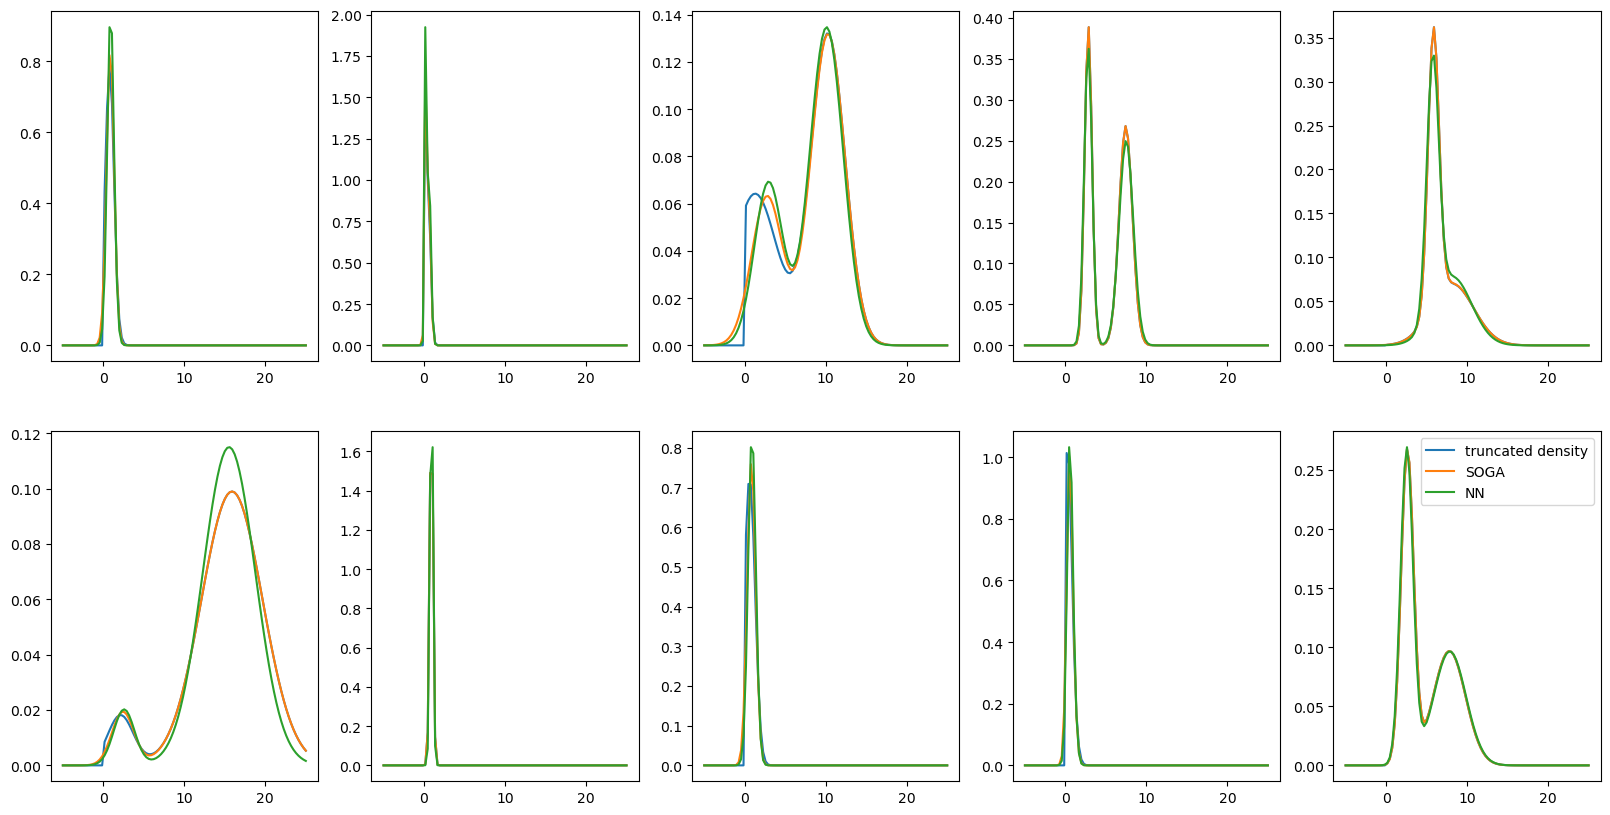

In [112]:
x = np.linspace(-5,25,100)

plt.figure(figsize=(20,10))
for i in range(10):

    y_trunc = trunc_gm_density(x, test_weights[i], test_means[i], test_covs[i])
    y_soga = gm_density(x, soga_weights[i], soga_means[i], soga_covs[i])
    y_nn = gm_density(x, pred_weights[i], pred_means[i], pred_covs[i])

    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_soga, label='SOGA')
    plt.plot(x, y_nn, label='NN')

plt.legend()